# **Mini Project 1**

0. Requirements:
   
   If you do not have the following packages installed, run the command below to install them.

In [1]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install nltk
!pip install codecarbon
!pip install shap

  Using cached termcolor-3.3.0-py3-none-any.whl.metadata (6.5 kB)
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 10.2 MB/s  0:00:00

   ---- ----------------------------------- 1/9 [termcolor]
   -------- ------------------------------- 2/9 [rapidfuzz]
   -------- ------------------------------- 2/9 [rapidfuzz]
   -------- ------------------------------- 2/9 [rapidfuzz]
   -------- ------------------------------- 2/9 [rapidfuzz]
   -------- ------------------------------- 2/9 [rapidfuzz]
   ----------------- ---------------------- 4/9 [questionary]
   ----------------- ---------------------- 4/9 [questionary]
   ----------------- ---------------------- 4/9 [questionary]
  Attempting uninstall: httpx
   ----------------- ---------------------- 4/9 [questionary]
    Found existing installation: httpx 0.28.1
   ----------------- ---------------------- 4/9 [questionary]
    Uninstalling httpx-0.28.1:
   ----------

1. Data Preparation:
   
    Goal: Load and inspect the IMDb dataset containing movie reviews labeled with positive and negative sentiments.(https://ai.stanford.edu/%7Eamaas/data/sentiment/)
    
    Task: Read the dataset, store the reviews and their associated sentiments, and explore the dataset to understand its structure.

In [3]:
import os #permet de manipuler des fichiers et des dossiers
import pandas as pd #permet de manipuler des données sous forme de tableaux
import numpy as np #permet de faire des calculs et gérer des tableaux numériques
import re #Nouveau, bibliothèque pour manipuler du texte, nous formons un motif de recherche
import shap #Nouveau, bibliothèque qui va attribuer un score à chaque mot qui pousse la prédiction vers une classe
import seaborn as sns #permet de visualiser des graphes
import matplotlib.pyplot as plt #permet de visualiser des graphes
from nltk.corpus import stopwords #importe une liste de mots courants
from nltk.stem import PorterStemmer #permet de réduire les mots à leur racine (ex. running to run)
from sklearn.feature_extraction.text import TfidfVectorizer #permt de convertir le texte en nombre en calculant l'importance des mots
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve #l'algorithme
from sklearn.linear_model import LogisticRegression #l'algorithme
from sklearn.metrics import classification_report, confusion_matrix #permet d'importer la matrice de confusion
from codecarbon import EmissionsTracker #permet de mesurer l'empreinte carbone

basepath = 'aclImdb' #donner le nom du dossier racine
labels = {'pos': 1, 'neg': 0} #crée un dictionnaire
all_reviews = [] #crée une liste vide

for s in ('test', 'train'): #parcourir test et train
    for l in ('pos', 'neg'): #parcourir both labels
        path = os.path.join(basepath, s, l) #construit un chemin d'accès exact
        
        for file in sorted(os.listdir(path)): #regarde tous les fichiers qui sont dans le path
            with open(os.path.join(path, file), 'r', encoding='utf-8') as infile: #ouvrir un fichier et le fermer
                txt = infile.read() #enreigistre le contenu dans le variable txt
            all_reviews.append([txt, labels[l]]) #crée un liste qui contient le contenu lu et son label (positif ou négatif)

df = pd.DataFrame(all_reviews, columns=['review', 'sentiment']) #crée un tableau qui est transformé de notre liste avec les noms de columes review et sentiment

np.random.seed(0) #mélange de la meme manière
fd = df.reindex(np.random.permutation(df.index)) #mélange les lignes

print("Nombre de lignes :", len(df)) #Affiché le nombre de ligne

df.head() #affiche les 5 première lignes

Nombre de lignes : 50000


,review,sentiment
11841,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
19602,OK... so... I really like Kris Kristofferson a...,0
45519,"***SPOILER*** Do not read this, if you think a...",0
25747,hi for all the people who have seen this wonde...,1
42642,"I recently bought the DVD, forgetting just how...",0


In [4]:
# Donne le nombre de lignes, de colonnes et vérifie s'il y a des données manquantes
df.info()

# Affiche les 5 premières lignes
df.head()

# Compte combien de 0 (négatif) et de 1 (positif) tu as
print(df['sentiment'].value_counts())

# Voir la longueur moyenne des critiques
print(df['review'].apply(len).describe())

# Save the work we just did
df.to_csv('movie_data.csv', index=False, encoding='utf-8')

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 11841 to 2732
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
sentiment
1    25000
0    25000
Name: count, dtype: int64
count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: review, dtype: float64


2. Text Preprocessing:
   
    Goal: Clean and preprocess the text data to remove noise and prepare it for analysis.
    
    Task: Remove unnecessary characters (e.g., HTML tags, punctuation), convert text to lowercase, and process words by removing stop words and stemming/lemmatizing them.

In [5]:
# TASK 2: Text Preprocessing 

import re

def preprocessor(text):

    text = re.sub('<[^>]*>', '', text) # Remove HTML tags

    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text) #Temporarily store emoticons

    #remplace non-alphanumériques par un espace, réattache les émoticônes, enlève - pour uniformiser
    text = (re.sub('[\W]+', ' ', text.lower()) + 
            ' '.join(emoticons).replace('-', ''))
    
    return text #renvoie la chaine de caractères nttoyée

df['review'] = df['review'].apply(preprocessor) #applique la fonction à chaque ligne de la colonne review du tableau df

In [6]:
# Ta phrase de test "sale"
test_review = '</a>This is a <b>BAD</b> movie!!! :( <br /> I loved it :)'

# Appel de la fonction
cleaned_result = preprocessor(test_review)

print(f"Avant : {test_review}")
print(f"Après : {cleaned_result}")

Avant : </a>This is a <b>BAD</b> movie!!! :( <br /> I loved it :)
Après : this is a bad movie i loved it :( :)


In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords') #télécharge la liste des mots vides, ex: the
porter = PorterStemmer() #crée un outil de stremming, ex: running to run
stop = stopwords.words('english') #crée un variable de la liste de stopwords

def tokenizer(text): #Découpe simplement le texte en mots.
    return text.split()

def tokenizer_porter(text): #Découpe le texte et réduit chaque mot à sa racine (stemming).
    return [porter.stem(word) for word in text.split()]

example_text = 'a runner likes running and runs a lot'
processed_text = [w for w in tokenizer_porter(example_text) if w not in stop]

print(processed_text)

['runner', 'like', 'run', 'run', 'lot']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wangming\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3. Feature Extraction:

    Goal: Transform the cleaned text into numerical features for machine learning.
   
    Task: Use a vectorization technique such as TF-IDF to convert the text into a numerical matrix that captures the importance of each word in the dataset.

In [18]:
# TASK 3: Feature Extraction 

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# On divise le dataset en deux (25k entraînement / 25k test)
X_train = df.iloc[:25000, 0].values  # Les 25 000 premières lignes réelles
y_train = df.iloc[:25000, 1].values

X_test = df.iloc[25000:, 0].values   # Tout le reste (les 25 000 suivantes)
y_test = df.iloc[25000:, 1].values

print(f"Ensembles créés : Train={len(X_train)}, Test={len(X_test)}")

# TF-IDF: Term Frequency-Inverse Document Frequency, il transforme les mots en chiffres significatifs
tfidf = TfidfVectorizer(strip_accents=None, 
                        lowercase=False, 
                        preprocessor=None,
                        tokenizer=tokenizer_porter,
                        use_idf=True, 
                        norm='l2', 
                        smooth_idf=True)

print("Vectorisation en cours")

# Transformation du texte en matrice numérique
# fit_transform apprend le vocabulaire et transforme X_train
X_train_tfidf = tfidf.fit_transform(X_train)

# transform utilise le vocabulaire appris pour transformer X_test
X_test_tfidf = tfidf.transform(X_test)

print(f"Dimensions de la matrice d'entraînement : {X_train_tfidf.shape}")

Ensembles créés : Train=25000, Test=25000
Vectorisation en cours


C:\Users\wangming\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Dimensions de la matrice d'entraînement : (25000, 54490)


4. Model Training:

    Goal: Train a machine learning model to classify reviews based on their sentiment.
    
    Task: Split the dataset into training and testing sets, train a Logistic Regression model, and evaluate its performance on the test data.

In [19]:
# TASK 4: Model Training 

# TASK 8: Track emissions during model training

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

#définir notre pipeline
tfidf = TfidfVectorizer(strip_accents=None, 
                        lowercase=False, 
                        preprocessor=None)

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0, solver='liblinear'))])

#définir notre Parameter Grid
param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]}]

#configure l'outil de recherche, croisse-validation 5 pils
gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5, verbose=2, n_jobs=-1)

print("Running GridSearch")
gs_lr_tfidf.fit(X_train, y_train) #lance l'entrainement

print(f'Best parameter set: {gs_lr_tfidf.best_params_}')
print(f'CV Accuracy: {gs_lr_tfidf.best_score_:.3f}')

clf = gs_lr_tfidf.best_estimator_
print(f'Test Accuracy: {clf.score(X_test, y_test):.3f}')

Running GridSearch
Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\wangming\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\wangming\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


Best parameter set: {'clf__C': 10.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x00000254B69A3880>}
CV Accuracy: 0.897
Test Accuracy: 0.899


5. Model Evaluation:

    Goal: Assess the performance of your model using appropriate metrics.
    
    Task: Evaluate precision, recall, and F1-score of the Logistic Regression model. Use these metrics to identify the strengths and weaknesses of your system. Visualize the Confusion Matrix to better understand how well the model classifies positive and negative reviews. Additionally, test the model with a new review, preprocess it, make a prediction, and display the result. Example: test it with a new review such as:
    "The movie had great visuals, but the storyline was dull and predictable." The expected output might be: Negative Sentiment.

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     12527
           1       0.90      0.90      0.90     12473

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



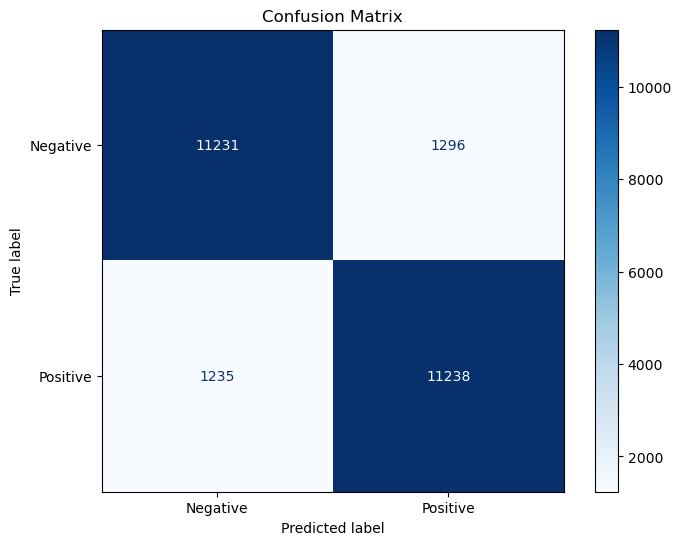

Review: The movie had great visuals but the storyline was dull and predictable.
Predicted Sentiment: Negative


In [20]:
# TASK 5: Model Evaluation 

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Classification Report
y_pred = gs_lr_tfidf.best_estimator_.predict(X_test) #utilise le meilleur estimateur trouvé par GridSearch pour prédire sur le test set
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 2. Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)

# 3. Plot the Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix')
plt.show()

# 4. Test with a new review
review = "The movie had great visuals but the storyline was dull and predictable."

cleaned_review = preprocessor(review)
prediction = gs_lr_tfidf.best_estimator_.predict([cleaned_review])[0]

sentiment = "Positive" if prediction == 1 else "Negative"
print(f"Review: {review}")
print(f"Predicted Sentiment: {sentiment}")

6. Hyperparameter Tuning:

    Goal: Optimize your Logistic Regression model by tuning its hyperparameters.
   
    Task: Use an optimization method to find the best parameters for your model and improve its accuracy.

In [22]:
# TASK 6: Hyperparameter Tuning 

# TASK 8: Track emissions during Hyperparameter Tuning

from codecarbon import EmissionsTracker
from sklearn.model_selection import GridSearchCV

tracker = EmissionsTracker() #CodeCarbon
tracker.start()

# TASK 6: Hyperparameter Tuning 
param_grid = {'clf__C': [0.1, 1.0, 10.0, 100.0]}

gs = GridSearchCV(estimator=lr_tfidf, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=5, 
                  verbose=1, 
                  n_jobs=-1)

print("Recherche des meilleurs paramètres en cours...")
gs.fit(X_train, y_train)

emissions = tracker.stop()

print(f"Emissions during hyperparameter tuning: {emissions} kgCO2e")
print(f"Best Parameters: {gs.best_params_}")

[codecarbon WARNING @ 20:26:27] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 20:26:27] [setup] RAM Tracking...
[codecarbon INFO @ 20:26:27] [setup] CPU Tracking...
[codecarbon WARNING @ 20:26:27] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 20:26:27] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz
[codecarbon WARNING @ 20:26:27] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 20:26:27] [setup] GPU Tracking...
[codecarbon INFO @ 20:26:27] No GPU found.
[codecarbon INFO @ 20:26:27] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 20:26:27] >>> Tracker's metadat

Recherche des meilleurs paramètres en cours...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[codecarbon INFO @ 20:26:42] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:26:42] Delta energy consumed for CPU with constant : 0.000477 kWh, power : 112.0 W
[codecarbon INFO @ 20:26:42] Energy consumed for All CPU : 0.000477 kWh
[codecarbon INFO @ 20:26:42] 0.000518 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 20:26:57] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:26:57] Delta energy consumed for CPU with constant : 0.000458 kWh, power : 112.0 W
[codecarbon INFO @ 20:26:57] Energy consumed for All CPU : 0.000935 kWh
[codecarbon INFO @ 20:26:57] 0.001017 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 20:27:06] Energy consumed for RAM : 0.000108 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:27:06] Delta energy consumed for CPU with constant : 0.000280 kWh, power : 112.0 W
[codecarbon INFO @ 20:27:06] Energy consumed for All 

Emissions during hyperparameter tuning: 5.207676898348688e-06 kgCO2e
Best Parameters: {'clf__C': 10.0}


7. Learning Curve Analysis:

    Goal: Diagnose your model's performance by plotting learning curves.
   
    Task: Analyze training and validation performance as a function of the training set size to identify underfitting or overfitting issues.


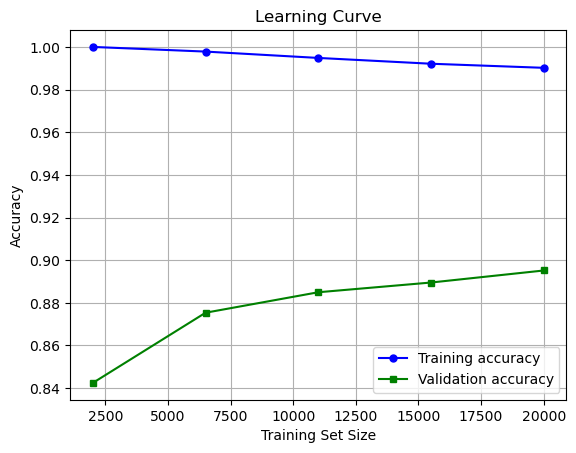

In [23]:
# TASK 7: Learning Curve Analysis

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=gs.best_estimator_,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=5,
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, label='Validation accuracy')

plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

9. Ethical Considerations and Explainability:

    Goal: Discuss the ethics in using and deploying your AI-based solution by investigating and implementing suitable explainability methods.
    
    Task: Understanding how a machine learning model makes predictions is crucial for ensuring transparency, fairness, and accountability in AI deployment. One of the widely used techniques for model explainability is SHAP (SHapley Additive exPlanations), which helps determine how much each feature (word) contributes to a prediction.
    In this task, you will use SHAP to analyze the impact of individual words on sentiment classification. This will allow you to visualize which words increase or decrease the probability of a positive or negative sentiment prediction. Additionally, discuss key aspects such as potential biases in the model, fairness in outcomes, and accountability in AI decision-making. You can find more information here: https://shap.readthedocs.io/en/latest/generated/shap.Explanation.html

C:\Users\wangming\AppData\Local\Temp\ipykernel_15020\3147007027.py:27: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_sample_transformed, feature_names=feature_names)


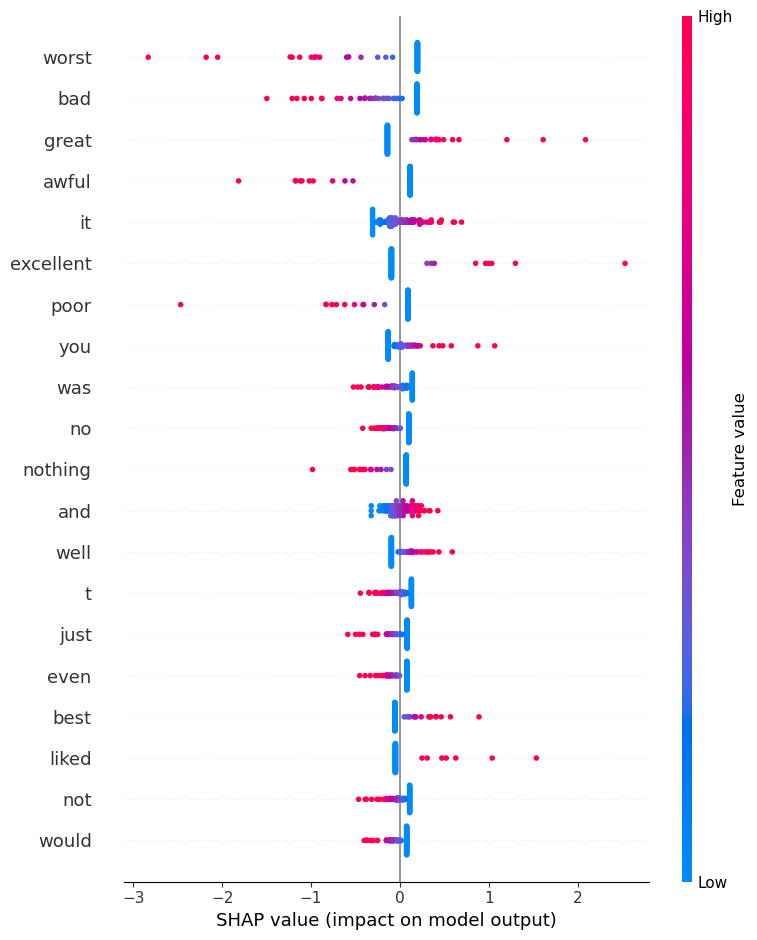

In [24]:
# TASK 9: Ethical Considerations & Explainability

import shap
import numpy as np

#extraction des composants
#parce que le modèle est le vectoriseur sont ensemble, alors faut les séparer pour SHAP
best_pipe = gs_lr_tfidf.best_estimator_ #prends le meilleur modèle qui est fait avec le best estimator
fitted_tfidf = best_pipe.named_steps['vect'] #isole l'étape de vectorisation
final_clf = best_pipe.named_steps['clf'] #isole l'étape de régression logistique

#récupre les mots
feature_names = fitted_tfidf.get_feature_names_out() #reprends les vrais mots

#préparation un échantillon
X_test_sample_raw = X_test[:100] 
X_test_sample_transformed = fitted_tfidf.transform(X_test_sample_raw).toarray() #On transforme ces 100 textes en nombres 
#et on convertit le résultat en un format "dense" que SHAP peut lire facilement.

#config. SHAP
explainer = shap.LinearExplainer(final_clf, 
                                 shap.maskers.Independent(data=X_test_sample_transformed),
                                 feature_names=feature_names)

shap_values = explainer(X_test_sample_transformed)

shap.summary_plot(shap_values, X_test_sample_transformed, feature_names=feature_names)

10. Deployment Considerations for Embedded Systems:

    Goal: Optimize and convert the trained logistic regression model for deployment on embedded systems like Arduino
    
    Task: To deploy the trained logistic regression model on a resource-constrained embedded system like an Arduino, we must optimize and convert the model into a format suitable for execution in an environment with limited memory and processing power. Since embedded systems do not support direct execution of machine learning models trained in Python, we extract the model’s learned parameters—namely, the weights and bias—after training. These parameters are then quantized to fixed-point integers to eliminate the need for floating-point calculations, which are inefficient on microcontrollers.
    Once quantization is applied, we generate a C++ .h header file containing the model’s coefficients and bias, formatted in a way that allows direct use within an Arduino sketch. The final model is optimized to perform inference using integer arithmetic, making it both lightweight and efficient for deployment on microcontrollers. You can find more information here: https://medium.com/@thommaskevin/tinyml-binomial-logistic-regression-0fdbf00e6765

In [25]:
# TASK 10: Deployment Considerations (Model Quantization & Export for Arduino)

model = gs_lr_tfidf.best_estimator_.named_steps['clf'] #récupère l'algorithme de classification
vect = gs_lr_tfidf.best_estimator_.named_steps['vect'] #récupère le vectoriseur

#extraction des poids et du biais
weights = model.coef_[0]
bias = model.intercept_[0] #la valeur de départ avant même de lire les mots.

scale = 1000
q_weights = (weights * scale).astype(int) #transforme les poids en nombres integers
q_bias = int(bias * scale)#transforme les biais en nombres integers

cpp_code = f"""
#ifndef LOGISTIC_REGRESSOR_H
#define LOGISTIC_REGRESSOR_H

class LogisticRegressor {{
    public:
        int predict(int* features, int length) {{
            long sum = {q_bias};
            for (int i = 0; i < length; i++) {{
                sum += (long)features[i] * weights[i];
            }}
            return (sum > 0) ? 1 : 0; // 1 = Positif, 0 = Négatif
        }}

    private:
        int weights[{len(q_weights)}] = {{ {', '.join(map(str, q_weights[:50]))} ... }}; 
}};
#endif
"""

with open('LogisticRegressor.h', 'w') as f:
    f.write(cpp_code)

print("Fichier .h généré pour l'Arduino !")

Fichier .h généré pour l'Arduino !
